
# Burkina Faso Survey — Data cleaning

## 0. Paths & parameters
Defining al the necessary file paths and parameters that will be used throughout the notebook

In [1]:

RAW_SURVEY = r"BF_survey.csv"
ROSTER_TSV = r"roster2.tsv"
OUT_CLEAN  = r"BF_ML_ready.csv"
RANDOM_SEED = 42  # for reproducible sex imputation by class

# KNN Imputer settings
K_FOR_KNN = 5


## 1. Imports
###Python libraries that are necessary for data handling, cleaning, and analysis. 

In [2]:

import pandas as pd
import numpy as np
import re
import warnings
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer

warnings.filterwarnings("ignore")


## 2. Load raw survey & roster; canonicalize columns
The BF survey data contains individual responses from the children in ABC school Bobo-Dioulassi in Burkina Faso, while the roster provides a list of the gender distribution within the school. Afterwards the datasets were column names and format was standardizes so they would align correctly, creating consistent base for later merging and analysis.

In [3]:

def canonicalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip().replace("\xa0", " ").replace("\n"," ").strip() for c in df.columns]
    df.columns = [" ".join(c.split()) for c in df.columns]  # collapse multiple spaces
    return df

raw = pd.read_csv(RAW_SURVEY, dtype=str, encoding="utf-8", na_values=["", " ", "NaN", "nan", "NA"])
roster = pd.read_csv(ROSTER_TSV, sep="\t", dtype=str, encoding="utf-8", na_values=["", " ", "NaN","nan","NA"])

raw  = canonicalize_columns(raw)
roster = canonicalize_columns(roster)

# Also strip surrounding whitespace inside string cells
raw = raw.applymap(lambda x: x.strip() if isinstance(x, str) else x)
roster = roster.applymap(lambda x: x.strip() if isinstance(x, str) else x)

raw.head(3)


,ID,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,T13,T14,Sex,Age,Class,school every day,share phone family,electricity at home,parents rules phone,Phone purpose
0,1,4,1,4,4,2,1,3,4,4,...,0,4,1,15,10,0,0,1,0,Communication
1,2,4,1,1,2,1,1,3,1,1,...,1,0,0,14,10,0,0,0,0,"School, Games"
2,3,4,4,4,4,4,4,2,4,4,...,0,0,1,14,10,0,NaN,0,0,Communication


## 2b. Raw data overview
Generating initial overview to understand the structure and quality of the variables in the data. 

The overview shows us: the number of rows and columns, the column name preview, the proportion of missing values per variable, mainly the top 10 variables with missing values. Overview of sex distribution(gender), the percentage of missing value, and duplications 

This overview allows for a quick quality assessment of the data and helps us to identify the variables that needs work. 

In [4]:
# General shape & preview
print(f"Total rows: {len(raw)}")
print(f"Total columns: {len(raw.columns)}\n")

print("Column name preview:")
print(list(raw.columns)[:15], "...\n")

# Basic info
na_counts = raw.isna().sum()
na_percent = (na_counts / len(raw) * 100).round(1)
missing_summary = pd.DataFrame({
    "Missing_Values": na_counts,
    "Missing_%": na_percent
}).sort_values("Missing_%", ascending=False)

print("Top 10 columns with most missing values:\n")
display(missing_summary.head(10))

# Sex distribution
sex_col_guess = None
for c in raw.columns:
    if "sex" in c.lower() or "gender" in c.lower():
        sex_col_guess = c
        break

if sex_col_guess:
    print(f"\nDetected sex column: {sex_col_guess}\n")
    print("Sex column raw value counts:")
    print(raw[sex_col_guess].value_counts(dropna=False))
else:
    print("\n Could not auto-detect a 'Sex' column (check column names manually).")

# Duplication check
dupes = raw.duplicated().sum()
print(f"\nDuplicate rows detected: {dupes}")

# General missing data ratio
total_cells = raw.shape[0] * raw.shape[1]
missing_cells = raw.isna().sum().sum()
missing_ratio = missing_cells / total_cells
print(f"\nOverall missing value ratio: {missing_ratio:.2%}")

assert raw.shape[0] > 0 and raw.shape[1] > 0, "Empty input?"
assert raw.columns.is_unique, "Duplicate column names in raw file."
print("Raw integrity checks passed.")


Total rows: 674
Total columns: 50

Column name preview:
['ID', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14'] ...

Top 10 columns with most missing values:



,Missing_Values,Missing_%
T14,161,23.9
T13,137,20.3
H11,66,9.8
H12,57,8.5
H10,52,7.7
H9,48,7.1
A5,44,6.5
Sex,43,6.4
T5,39,5.8
T7,38,5.6



Detected sex column: Sex

Sex column raw value counts:
Sex
1      366
0      238
NaN     43
2       25
5        1
3        1
Name: count, dtype: int64

Duplicate rows detected: 0

Overall missing value ratio: 4.38%
Raw integrity checks passed.


## 3. Detect blocks (A*, H*, T*) and overview

Identifying and organizing the main thematic blocks within the Burkina Faso survey data. Each block corresponds to a specific area of focus. A block covers questions on attention. The H block refers to Happiness and the T block includes questions on mobile phone usage. Detecting this blocks help structure the analysis by grouping similar variables together. 

In [5]:

cols = list(raw.columns)

# Helper to extract like A1, A2, etc...
def block_cols(prefix):
    out = [c for c in cols if c.upper().startswith(prefix) and c[1:].strip().replace('_','').isdigit()]
    # robust numeric ordering
    def num(c):
        digits = "".join(ch for ch in c if ch.isdigit())
        return int(digits) if digits else 0
    return sorted(out, key=num)

A_cols = block_cols("A")
H_cols = block_cols("H")
T_cols = block_cols("T")

print("Detected A_cols:", A_cols)
print("Detected H_cols:", H_cols)
print("Detected T_cols:", T_cols)



Detected A_cols: ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15']
Detected H_cols: ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12']
Detected T_cols: ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14']


## 4. Sex fixing via class-level proportions from roster

In this section, the missing or inconsistent gender information in the Burkina Faso survey data is addessed by using the roster file from ABC School. The roster provides reliable counts of male and female students, which allows us to estimate or correct missing valies in the survey dataset. By applying class-level gender proportions, the overall distribution of male and female in the survey aligns with the verified totals from the roster, improving the accuracy adn representativeness of the dataset while maintaining the consistency between the survey and the roster data. 

bootstrap: load + canonicalize + make working copies

In [6]:
# Return a copy with cleaned column names (trim & collapse inner spaces)
def canonicalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.columns = [" ".join(str(c).strip().split()) for c in out.columns]
    return out

def _load_csv_safe(path, **kw):
    return pd.read_csv(path, **kw)

# Re-load RAW SURVEY if missing
if "raw" not in globals() or raw is None or not hasattr(raw, "copy"):
    raw = _load_csv_safe(
        RAW_SURVEY,
        dtype=str, encoding="utf-8",
        na_values=["", " ", "NaN", "nan", "NA"]
    )

# Re-load ROSTER (TSV) if missing
if "roster" not in globals() or roster is None or not hasattr(roster, "copy"):
    roster = _load_csv_safe(
        ROSTER_TSV,
        sep="\t", dtype=str, encoding="utf-8",
        na_values=["", " ", "NaN", "nan", "NA"]
    )

# Canonicalize headers
raw = canonicalize_columns(raw)
roster = canonicalize_columns(roster)

# Strip whitespace inside string cells (idempotent)
raw = raw.applymap(lambda x: x.strip() if isinstance(x, str) else x)
roster = roster.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Working copies for the rest of Part 4
df = raw.copy()
roster = roster.copy()


Find required columns and normalize fields

In [7]:
# Ensure working copies
df = df.copy()
roster = roster.copy()

# Normalize Sex values

# Convert numeric codes to Male/Female or NaN
def norm_survey_sex(x):
    """"""
    if pd.isna(x): 
        return np.nan
    s = str(x).strip()
    if s == "1":
        return "Female"
    elif s == "0":
        return "Male"
    elif s == "2":
        return np.nan  # invalid -> missing
    return np.nan

# Convert F/M to Female/Male
def norm_roster_sex(x):
    if pd.isna(x): 
        return np.nan
    s = str(x).strip().upper()
    if s == "F":
        return "Female"
    elif s == "M":
        return "Male"
    return np.nan


# Normalize Class
def clean_class(x):
    if pd.isna(x): 
        return np.nan
    s = str(x).strip().upper()
    s = re.sub(r"\s+", "", s)  # remove internal spaces
    s = s.replace("É", "E").replace("È", "E")
    return s

df["Class"] = df["Class"].apply(clean_class)
roster["Class"] = roster["Class"].apply(clean_class)

# Quick sanity check
print("Survey 'Sex' distribution:")
print(df["Sex"].value_counts(dropna=False))
print("\nRoster 'Sex' distribution:")
print(roster["Sex"].value_counts(dropna=False))
print("\nExample classes from survey:", df["Class"].unique()[:10])
print("Example classes from roster:", roster["Class"].unique()[:10])


Survey 'Sex' distribution:
Sex
1      366
0      238
NaN     43
2       25
5        1
3        1
Name: count, dtype: int64

Roster 'Sex' distribution:
Sex
F    470
M    353
Name: count, dtype: int64

Example classes from survey: ['10' '7' '0' nan '8' '9' '11' '12' '13']
Example classes from roster: ['7' '8' '9' '10' '11' '12' '13']


Proportion by class

In [8]:
# Grade-level Female/Male proportions from the roster
prop_grade = (
    roster.dropna(subset=["Class", "Sex"]) # ensure both exist
          .groupby(["Class", "Sex"]).size()
          .groupby(level=0).apply(lambda s: s / s.sum()) # within-class proportions
          .unstack(fill_value=0.0)
          .rename(columns={"Female": "Prop_Female_g", "Male": "Prop_Male_g"})
)

# Remove any index name and force a clean numeric index
prop_grade.index.name = None
prop_grade = prop_grade.reset_index(drop=True)

# Create a fresh "Class_key" column directly from roster order
prop_grade.insert(0, "Class_key", roster["Class"].dropna().unique()[:len(prop_grade)])

# Remove possible duplicate helper columns from df
for c in ["Prop_Female_g", "Prop_Male_g", "Class_key"]:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

# Merge safely by class name (from survey)
df = df.merge(prop_grade, left_on="Class", right_on="Class_key", how="left")
df.drop(columns=["Class_key"], inplace=True, errors="ignore")

display(prop_grade.head())


Sex,Class_key,F,M
0,7,0.549180,0.450820
1,8,0.558824,0.441176
2,9,0.641975,0.358025
3,10,0.703704,0.296296
4,11,0.490099,0.509901


Final clean up

In [9]:
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

# For rows where mask_bool is True, fill df['Sex'] by sampling Female/Male using that row's Prop_Female_g as p(Female).
def stochastic_fill(mask_bool, p_female_series):

    idx = df.index[mask_bool]
    if len(idx) == 0:
        return 0
    draws = rng.random(len(idx))
    df.loc[idx, "Sex"] = np.where(
        draws < p_female_series.values[:len(idx)],
        "Female",
        "Male"
    )
    return int(len(idx))

# Map raw survey codes to 'Female' / 'Male' / NaN.
def normalize_code(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in {"1", "f", "female"}:
        return "Female"
    if s in {"0", "m", "male"}:
        return "Male"
    return np.nan  # bad / other


# Make sure we have the grade-level female proportion column
if "Prop_Female_g" not in df.columns and "F" in df.columns:
    df = df.rename(columns={"F": "Prop_Female_g"})


# Normalize raw Sex codes first
df["Sex"] = df["Sex"].apply(normalize_code)

print("After initial normalization:\n", df["Sex"].value_counts(dropna=False))


# Impute any rows still missing Sex using grade proportions
mask_need_fill = df["Sex"].isna() & df["Prop_Female_g"].notna()
n_filled = stochastic_fill(mask_need_fill, df.loc[mask_need_fill, "Prop_Female_g"])
print(f"Grade-level imputation filled: {n_filled} students")


# Final cleanup: ensure only 'Female' / 'Male' remain; anything else -> NaN
df["Sex"] = df["Sex"].apply(lambda x: x if x in {"Female", "Male"} else np.nan)

print("\nFinal Sex distribution:\n", df["Sex"].value_counts(dropna=False))
print("Final Missing Sex:", int(df["Sex"].isna().sum()))


After initial normalization:
 Sex
Female    366
Male      238
NaN        70
Name: count, dtype: int64
Grade-level imputation filled: 70 students

Final Sex distribution:
 Sex
Female    402
Male      272
Name: count, dtype: int64
Final Missing Sex: 0


## 5. Phone ownership and duration

In this section, it examines both phone ownership and the duration of the phone use among the children. The goal is to understand patterns of access and engagement with mobile usage within the ABC School population. (The results from this section will later be used to explore potential associations between mobile phone behavior and attention and happiness does this make sense?) 

In [10]:
phone_years_col = "T13"
phone_months_col = "T14"

# clean & convert to numeric safely
df[phone_years_col]  = pd.to_numeric(df[phone_years_col],  errors="coerce").fillna(0)
df[phone_months_col] = pd.to_numeric(df[phone_months_col], errors="coerce").fillna(0)

# compute total phone ownership in months
df["Phone_total_months"] = (df[phone_years_col] * 12 + df[phone_months_col]).astype(int)

# mark non-owners (both 0)
df["Has_phone"] = np.where(df["Phone_total_months"] > 0, 1, 0)

# create friendly categorical label
df["Phone_status"] = df["Has_phone"].map({1: "Owns phone", 0: "No phone"})

# guard against impossible values
df.loc[df["Phone_total_months"] > 200, ["Phone_total_months", "Has_phone", "Phone_status"]] = [np.nan, 0, "No phone"]


# sanity check
print(df[["T13", "T14", "Phone_total_months", "Has_phone", "Phone_status"]].head())
print("\nPhone ownership summary:\n", df["Phone_status"].value_counts(dropna=False))


    T13  T14  Phone_total_months  Has_phone Phone_status
0   0.0  4.0                 4.0          1   Owns phone
1   1.0  0.0                12.0          1   Owns phone
2   0.0  0.0                 0.0          0     No phone
3   1.0  0.0                12.0          1   Owns phone
4  16.0  0.0               192.0          1   Owns phone

Phone ownership summary:
 Phone_status
Owns phone    402
No phone      272
Name: count, dtype: int64


## 6. Trim by missingness: >95% columns, >75% rows

The dataset is refined by removing variables with excessive missing values. Trimming by missingness helps ensure that the analysis is based on reliable and complete information. The trimming will retain variables with fratures and participants with sufficient data coverage to support accurate and meaningful statistical evaluation. 

In [47]:

# Capture which items were missing BEFORE any imputation
blocks_all = A_cols + H_cols + T_cols
missing_flags_before = df[blocks_all].isna().copy()
missing_flags_before.columns = [c + "_was_imputed" for c in blocks_all]

# Cast numeric blocks to numeric (non-numeric -> NaN) to evaluate missingness properly
for c in A_cols + H_cols + T_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Column trim (>95% missing)
col_missing = df.isna().mean()
drop_cols = list(col_missing[col_missing > 0.95].index)
df_trim = df.drop(columns=drop_cols)

# Row trim (>75% missing across the *kept* columns)
row_missing = df_trim.isna().mean(axis=1)
df_trim = df_trim.loc[row_missing <= 0.75].reset_index(drop=True)

# --- 1) Locate the age column robustly (handles 'Age' vs 'age' etc.) ---
age_col = None
for c in df_trim.columns:
    if c.strip().lower() == 'age':
        age_col = c
        break
if age_col is None:
    raise KeyError("No 'age' column found in df_trim.")

# --- 2) Coerce age to numeric (turns non-numeric into NaN) ---
before_rows = len(df_trim)
age_before_dtype = df_trim[age_col].dtype

# Count how many will become NaN after coercion (for logging)
tmp_age = pd.to_numeric(df_trim[age_col], errors='coerce')
n_new_nans = tmp_age.isna().sum() - df_trim[age_col].isna().sum()

df_trim[age_col] = tmp_age  # assign coerced numeric age

print(f"Age dtype before: {age_before_dtype} -> after: {df_trim[age_col].dtype}")
print(f"New NaNs created by coercion (non-numeric ages): {max(n_new_nans, 0)}")

# --- 3) Drop rows outside 8–23 (inclusive); also drop rows where age is NaN ---
mask_valid_age = df_trim[age_col].between(8, 23, inclusive='both')
mask_notna     = df_trim[age_col].notna()
df_trim = df_trim[mask_valid_age & mask_notna].copy()

print(f"Rows before filtering: {before_rows}")
print(f"Rows after filtering ages 8–23: {len(df_trim)}")
print(df_trim[age_col].describe())


print("Dropped columns:", drop_cols)
print("Remaining shape:", df_trim.shape)


Age dtype before: object -> after: float64
New NaNs created by coercion (non-numeric ages): 0
Rows before filtering: 674
Rows after filtering ages 8–23: 638
count    638.000000
mean      15.142633
std        2.532061
min       10.000000
25%       13.000000
50%       15.000000
75%       17.000000
max       23.000000
Name: Age, dtype: float64
Dropped columns: []
Remaining shape: (638, 55)



## 7. Reverse‑scoring
The scoring direction for certain survey items in the **Attention** and **Happiness** blocks to ensure that all scare are oriented consistently. 

- For **Attention**: items phrased as “difficulty / easily distracted / hard to…” are **reversed**.  
- For **Happiness**: items phrased negatively (e.g., *depressed, anxious, never safe, often alone*) are **reversed**.


Define reverse‑scoring lists

In [48]:

# Attention default reverse 
ATTENTION_REVERSE = [c for c in A_cols if any(x in c for x in ["A1","A2","A3","A4","A5","A6","A7","A8","A9","A15"])]
# Happiness default reverse (negatively worded)
HAPPINESS_REVERSE = [c for c in H_cols if any(x in c for x in ["H2","H4","H6","H9","H11"])]

ATTENTION_REVERSE, HAPPINESS_REVERSE

REV_CONF = {
    "ATTENTION_REVERSE": ATTENTION_REVERSE,
    "HAPPINESS_REVERSE": HAPPINESS_REVERSE
}


Apply reverse scoring (4‑point scales flipped to keep 4 = more, 1 = less)

In [49]:
def reverse_scale(series, low, high):
    # maps 1<->4, 2<->3 when (low, high) = (1,4)
    return high + low - series

# Reverse A/H where needed, ensure ranges before flipping
for c in ATTENTION_REVERSE:
    if c in df_trim.columns:
        df_trim[c] = reverse_scale(df_trim[c], 1, 4)

for c in HAPPINESS_REVERSE:
    if c in df_trim.columns:
        df_trim[c] = reverse_scale(df_trim[c], 1, 4)


## 8. KNN impute numeric missing values within each block

The remaining missing numeric values in the dataset using a K-Nearest Neighbors (KNN) imputation approach. KNN imputation estimates based on the most similar respondents within each block. This methos uses the relationships among nearby data points to infer realistic replacements, helping presevere the natuaral variability and structure of the survey responses. 

Start from reverse-scored + trimmed

In [50]:
df_imp = df_trim.copy()

# Exclude phone duration/ownership
protected_cols = ["T13", "T14", "Phone_total_months", "Has_phone", "Phone_status"]

# Identify column groups
force_binary = [
    "school every day",
    "share phone family",
    "electricity at home",
    "parents rules phone",
]
force_binary = [c for c in force_binary if c in df_imp.columns]

# Effective A/H/T lists = only columns that exist AND are not protected
A_cols_eff = [c for c in A_cols if c in df_imp.columns and c not in protected_cols]
H_cols_eff = [c for c in H_cols if c in df_imp.columns and c not in protected_cols]
T_cols_eff = [c for c in T_cols if c in df_imp.columns and c not in protected_cols]

# All Likert-style / behavioral items that should be imputed + rounded/clipped later
item_cols = A_cols_eff + H_cols_eff + T_cols_eff

# Numeric columns minus binaries & items
other_num = (
    df_imp.select_dtypes(include=[np.number]).columns
    .difference(item_cols + force_binary + protected_cols)
    .tolist()
)

# Categorical/string cols
cat_cols = df_imp.select_dtypes(include=["object", "string"]).columns.tolist()

Build imputers

In [51]:
knn = KNNImputer(n_neighbors=5, weights="distance")        # for Likert-style / T-block items
num_imp = SimpleImputer(strategy="median")                 # for other numeric
bin_imp = SimpleImputer(strategy="most_frequent")          # for binaries (0/1)
cat_imp = SimpleImputer(strategy="most_frequent")          # for categorical text

# Remove duplicates between groups to avoid collisions when rebuilding dataframe
all_groups = [item_cols, other_num, force_binary, cat_cols]
flat = [c for g in all_groups for c in g]
dupes = [c for c in flat if flat.count(c) > 1]

if dupes:
    print("Removing duplicated columns from imputation groups:", dupes)
    seen = set()
    item_cols    = [c for c in item_cols    if not (c in seen or seen.add(c))]
    other_num    = [c for c in other_num    if not (c in seen or seen.add(c))]
    force_binary = [c for c in force_binary if not (c in seen or seen.add(c))]
    cat_cols     = [c for c in cat_cols     if not (c in seen or seen.add(c))]

Removing duplicated columns from imputation groups: ['school every day', 'share phone family', 'electricity at home', 'parents rules phone', 'school every day', 'share phone family', 'electricity at home', 'parents rules phone']


Column transformer with prefixed outputs to guarantee uniqueness

In [52]:
pre = ColumnTransformer(
    transformers=[
        ("items", knn, item_cols),
        ("num",   num_imp, other_num),
        ("bin",   bin_imp, force_binary),
        ("cat",   cat_imp, cat_cols),
    ],
    remainder="passthrough",  # protected_cols (T13, T14) land here untouched
    verbose_feature_names_out=True,
)

arr = pre.fit_transform(df_imp)
feature_names = pre.get_feature_names_out()

# Strip sklearn prefixes like "items__A1" -> "A1"
feature_names = [n.split("__", 1)[-1] if "__" in n else n for n in feature_names]

# Build DataFrame and restore original column order
df_full = pd.DataFrame(arr, columns=feature_names, index=df_imp.index)
df_full = df_full[df_imp.columns]  # same order as input


Post-process: enforce integer ranges on the Likert-style stuff

In [53]:
def round_clip(df, cols, lo, hi):
    for c in cols:
        if c in df.columns:
            df[c] = (
                pd.to_numeric(df[c], errors="coerce")
                .round()
                .clip(lo, hi)
                .astype("Int64")
            )

# 4-point Likert (A + H)
round_clip(df_full, A_cols_eff, 1, 4)
round_clip(df_full, H_cols_eff, 1, 4)

# T-block Likert-ish (like tech/phone behavior frequency 1–7)
round_clip(df_full, T_cols_eff, 1, 7)

# Binary 0/1 questions (attendance, rules, etc.)
for c in force_binary:
    if c in df_full.columns:
        df_full[c] = (
            pd.to_numeric(df_full[c], errors="coerce")
            .round()
            .clip(0, 1)
            .astype("Int64")
        )

# Sex column: keep as string label for downstream models
if "Sex" in df_full.columns:
    df_full["Sex"] = df_full["Sex"].astype(str)

Validate integrity

In [54]:
# No missing values in non-protected model inputs
cols_to_check_missing = [
    c for c in df_full.columns
    if c not in protected_cols  # we only assert strict completeness on model features
]
assert df_full[cols_to_check_missing].isna().sum().sum() == 0, \
    "There are still missing values after imputation (excluding protected phone duration columns)."

# No decimals in the imputed/rounded groups
for c in item_cols + force_binary:
    if c in df_full.columns:
        s = pd.to_numeric(df_full[c], errors="coerce")
        assert np.allclose(s, s.round(), equal_nan=True), f"Column {c} still has decimals."

# Range checks for the Likert-style items, not phone duration vars
for c in A_cols_eff + H_cols_eff:
    if c in df_full.columns:
        v = pd.to_numeric(df_full[c], errors="coerce").astype("Int64")
        assert ((v >= 1) & (v <= 4)).all(), f"{c} out of 1-4 range"

for c in T_cols_eff:
    if c in df_full.columns:
        v = pd.to_numeric(df_full[c], errors="coerce").astype("Int64")
        assert ((v >= 1) & (v <= 7)).all(), f"{c} out of 1-7 range"

print("Global imputation complete — model features have no NaNs, are valid integers, and phone duration columns were preserved untouched.")
display(df_full.head(3))

Global imputation complete — model features have no NaNs, are valid integers, and phone duration columns were preserved untouched.


,ID,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,school every day,share phone family,electricity at home,parents rules phone,Phone purpose,Prop_Female_g,M,Phone_total_months,Has_phone,Phone_status
0,1,1,4,1,1,3,4,2,1,1,...,0,0,1,0,Communication,0.703704,0.296296,4.0,1.0,Owns phone
1,2,1,4,4,3,4,4,2,4,4,...,0,0,0,0,"School, Games",0.703704,0.296296,12.0,1.0,Owns phone
2,3,1,1,1,1,1,1,3,1,1,...,0,0,0,0,Communication,0.703704,0.296296,0.0,0.0,No phone


## 9. Compute per‑student block means

The summary measures for each student across the three main survey blocks **Attention (A), Happiness (H), Mobile Phone us (T)**. After cleaning, reverse scoring, and imputing missing values, this tsep condenses the multiple question-level responses into a single representative score per block for each student. 

In [55]:
def row_mean_safe(df, cols):
    cols = [c for c in cols if c in df.columns]
    if not cols:
        return pd.Series(np.nan, index=df.index)
    return df[cols].astype(float).mean(axis=1)

df_full["Attention_Score"]  = row_mean_safe(df_full, A_cols_eff)
df_full["Happiness_Score"]  = row_mean_safe(df_full, H_cols_eff)
df_full["PhoneUse_Score"]   = row_mean_safe(df_full, T_cols_eff)

# Sanity: means must be numeric and within expected bounds
if A_cols_eff: assert df_full["Attention_Score"].between(1, 4).all()
if H_cols_eff: assert df_full["Happiness_Score"].between(1, 4).all()
if T_cols_eff: assert df_full["PhoneUse_Score"].between(1, 7).all()

display(df_full[["Attention_Score","Happiness_Score","PhoneUse_Score"]].head())


,Attention_Score,Happiness_Score,PhoneUse_Score
0,2.266667,3.166667,4.583333
1,3.000000,3.583333,4.250000
2,1.333333,3.000000,1.083333
3,2.000000,2.916667,3.916667
4,2.066667,2.666667,3.833333


## 10. Final touches & export

The final vesion represents the completion of preprocessing and is ready for the transformation. 

In [56]:
# Columns to drop if present
drop_helpers = [
    "Grade_key", "Prop_Female_g", "Prop_Male_g", "M", "Class_norm", "Phone_status",
]
drop_helpers = [c for c in drop_helpers if c in df_full.columns]
if drop_helpers:
    df_final = df_full.drop(columns=drop_helpers)
else:
    df_final = df_full.copy()

# Add numeric Sex
if "Sex" in df_final.columns:
    df_final["Sex_binary"] = df_final["Sex"].map({"Female": 1, "Male": 0}).astype("Int64")
    df_final = df_final.drop(columns=["Sex"])

# Nice column order
id_col   = "ID" if "ID" in df_final.columns else None
front    = [c for c in [id_col, "Sex_binary", "Class_col"] if c and c in df_final.columns]
scores   = [c for c in ["Attention_Score","Happiness_Score","PhoneUse_Score"] if c in df_final.columns]
blocks   = [c for c in (A_cols_eff + H_cols_eff + T_cols_eff) if c in df_final.columns]
rest     = [c for c in df_final.columns if c not in set(front + scores + blocks)]
df_final = df_final[front + scores + blocks + rest]

# Save
df_final.to_csv(OUT_CLEAN, index=False, encoding="utf-8")
print(f"Wrote: {OUT_CLEAN}")
display(df_final.head(3))


Wrote: BF_ML_ready.csv


,ID,Sex_binary,Attention_Score,Happiness_Score,PhoneUse_Score,A1,A2,A3,A4,A5,...,T14,Age,Class,school every day,share phone family,electricity at home,parents rules phone,Phone purpose,Phone_total_months,Has_phone
0,1,1,2.266667,3.166667,4.583333,1,4,1,1,3,...,4.0,15.0,10,0,0,1,0,Communication,4.0,1.0
1,2,0,3.000000,3.583333,4.250000,1,4,4,3,4,...,0.0,14.0,10,0,0,0,0,"School, Games",12.0,1.0
2,3,1,1.333333,3.000000,1.083333,1,1,1,1,1,...,0.0,14.0,10,0,0,0,0,Communication,0.0,0.0


11. DISCRIPTION 

In [57]:
import matplotlib.pyplot as plt

#for c in df_final.columns:
  #  plt.hist(df_final[c].dropna(), bins=20, edgecolor='black')
   # plt.title("Distribution of " + c)
    #plt.xlabel(c)
    #plt.ylabel("Frequency")
    #plt.show()


Available columns: ['id', 'sex_binary', 'attention_score', 'happiness_score', 'phoneuse_score', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 'age', 'class', 'school every day', 'share phone family', 'electricity at home', 'parents rules phone', 'phone purpose', 'phone_total_months', 'has_phone']


UFuncTypeError: Cannot cast ufunc 'svd_n_s' input from dtype('O') to dtype('float64') with casting rule 'same_kind'

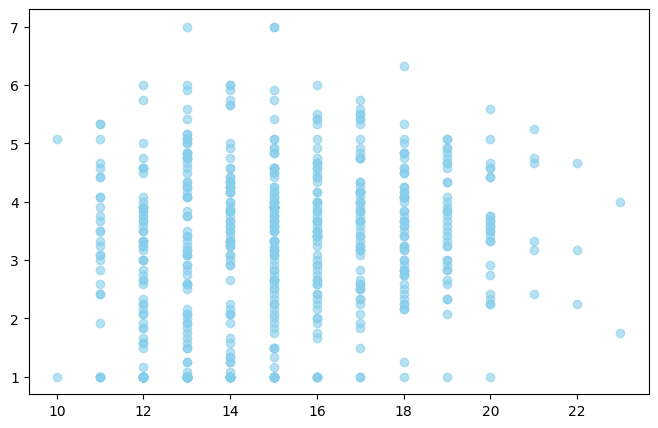

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Ensure columns are standardized ---
df_final.columns = df_final.columns.str.strip().str.lower()

# --- Check available columns ---
print("Available columns:", df_final.columns.tolist())

# Define the column names (adjust if they differ slightly)
age_col = 'age'
phone_col = 'phoneuse_score'

# --- 1️⃣ Scatterplot with regression line ---
plt.figure(figsize=(8, 5))
sns.regplot(
    data=df_final,
    x=age_col,
    y=phone_col,
    scatter_kws={'alpha':0.6, 'color':'skyblue'},
    line_kws={'color':'red', 'linewidth':2}
)
plt.title("Relationship Between Age and Mobile Phone Use", fontsize=14)
plt.xlabel("Age (years)", fontsize=12)
plt.ylabel("Mobile Phone Use Score", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Using columns -> age: 'age', phone use: 'phoneuse_score'


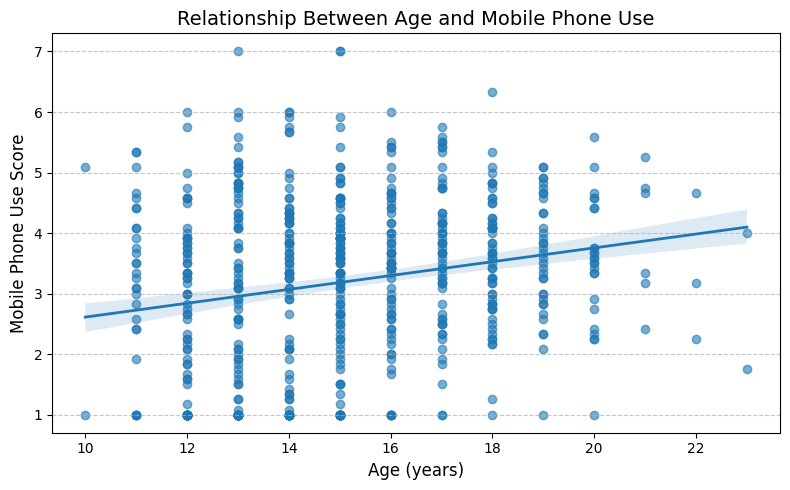

<Figure size 640x480 with 0 Axes>

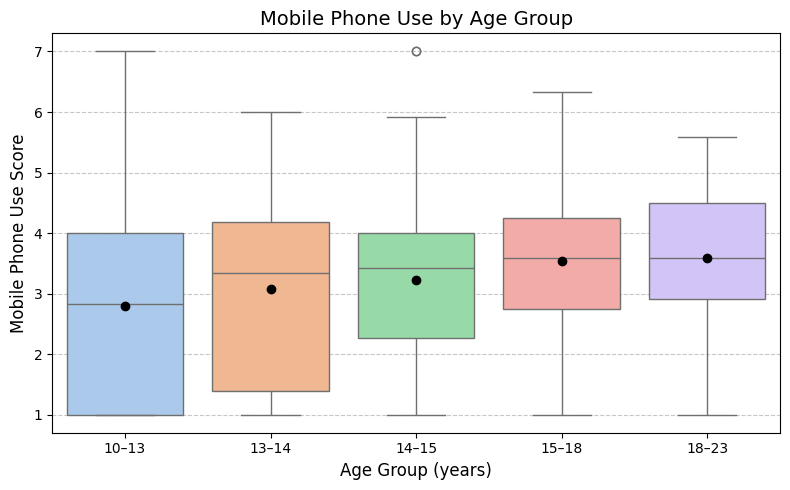

<Figure size 640x480 with 0 Axes>

In [59]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load (skip if already loaded) ---
df_final = pd.read_csv("BF_ML_ready.csv")

# --- Standardize column names once ---
df_final.columns = df_final.columns.str.strip().str.lower()

# --- Auto-detect column names ---
# candidates to be safe across versions
age_candidates   = ['age', 'age_years', 'student_age']
phone_candidates = ['mobile_phone_score', 'phoneuse_score', 't_score', 'phone_score']

def pick(col_options, cols):
    for c in col_options:
        if c in cols:
            return c
    raise KeyError(f"None of {col_options} found in columns: {list(cols)[:15]} ...")

age_col   = pick(age_candidates,   df_final.columns)
phone_col = pick(phone_candidates, df_final.columns)

print(f"Using columns -> age: '{age_col}', phone use: '{phone_col}'")

# --- Basic sanity: numeric casting (no errors if already numeric) ---
df_final[age_col]   = pd.to_numeric(df_final[age_col], errors='coerce')
df_final[phone_col] = pd.to_numeric(df_final[phone_col], errors='coerce')

# =========================
# 1) Scatter + regression
# =========================
plt.figure(figsize=(8, 5))
sns.regplot(
    data=df_final, x=age_col, y=phone_col,
    scatter_kws={'alpha':0.6}, line_kws={'linewidth':2}
)
plt.title("Relationship Between Age and Mobile Phone Use", fontsize=14)
plt.xlabel("Age (years)", fontsize=12)
plt.ylabel("Mobile Phone Use Score", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Save for Overleaf (optional)
plt.savefig("fig_phoneuse_vs_age.png", dpi=300, bbox_inches='tight')

# =========================
# 2) Boxplot by age groups
# =========================
# Create age groups using fixed bins if range is 8–21, else use quantiles
age_min, age_max = df_final[age_col].min(), df_final[age_col].max()

if age_min >= 7 and age_max <= 22:
    bins   = [7, 10, 13, 16, 19, 22]
    labels = ['8–10', '11–13', '14–16', '17–19', '20–21']
else:
    # fallback: 5 quantile-based groups with readable labels
    q = df_final[age_col].quantile([0, .2, .4, .6, .8, 1.0]).values
    bins   = np.unique(q)  # ensure strictly increasing
    labels = [f"{int(bins[i])}–{int(bins[i+1])}" for i in range(len(bins)-1)]

df_final['age_group'] = pd.cut(df_final[age_col], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_final, x='age_group', y=phone_col, palette='pastel', showmeans=True,
    meanprops={"marker":"o","markerfacecolor":"black","markeredgecolor":"black"}
)
plt.title("Mobile Phone Use by Age Group", fontsize=14)
plt.xlabel("Age Group (years)", fontsize=12)
plt.ylabel("Mobile Phone Use Score", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Save for Overleaf (optional)
plt.savefig("fig_phoneuse_by_agegroup.png", dpi=300, bbox_inches='tight')

